<a href="https://colab.research.google.com/github/Satwikram/Computer-Vision-Implementations/blob/main/Fine%20Tune%20ViT%20for%20Image%20Classification%20with%20%F0%9F%A4%97%20Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Setup

In [ ]:
pip install datasets transformers

In [2]:
from datasets import load_dataset

ds = load_dataset('beans')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [4]:
ex = ds['train'][400]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/healthy/healthy_train.206.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F551E3D1910>,
 'labels': 2}

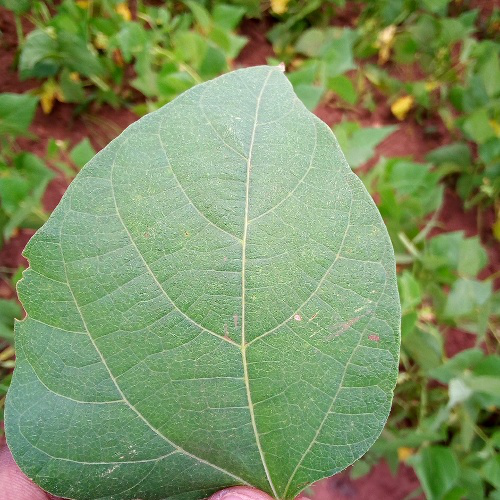

In [5]:
image = ex['image']
image

In [6]:
labels = ds['train'].features['labels']
labels

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [7]:
labels.int2str(ex['labels'])

'healthy'

### Function to display a grid of examples from each class

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

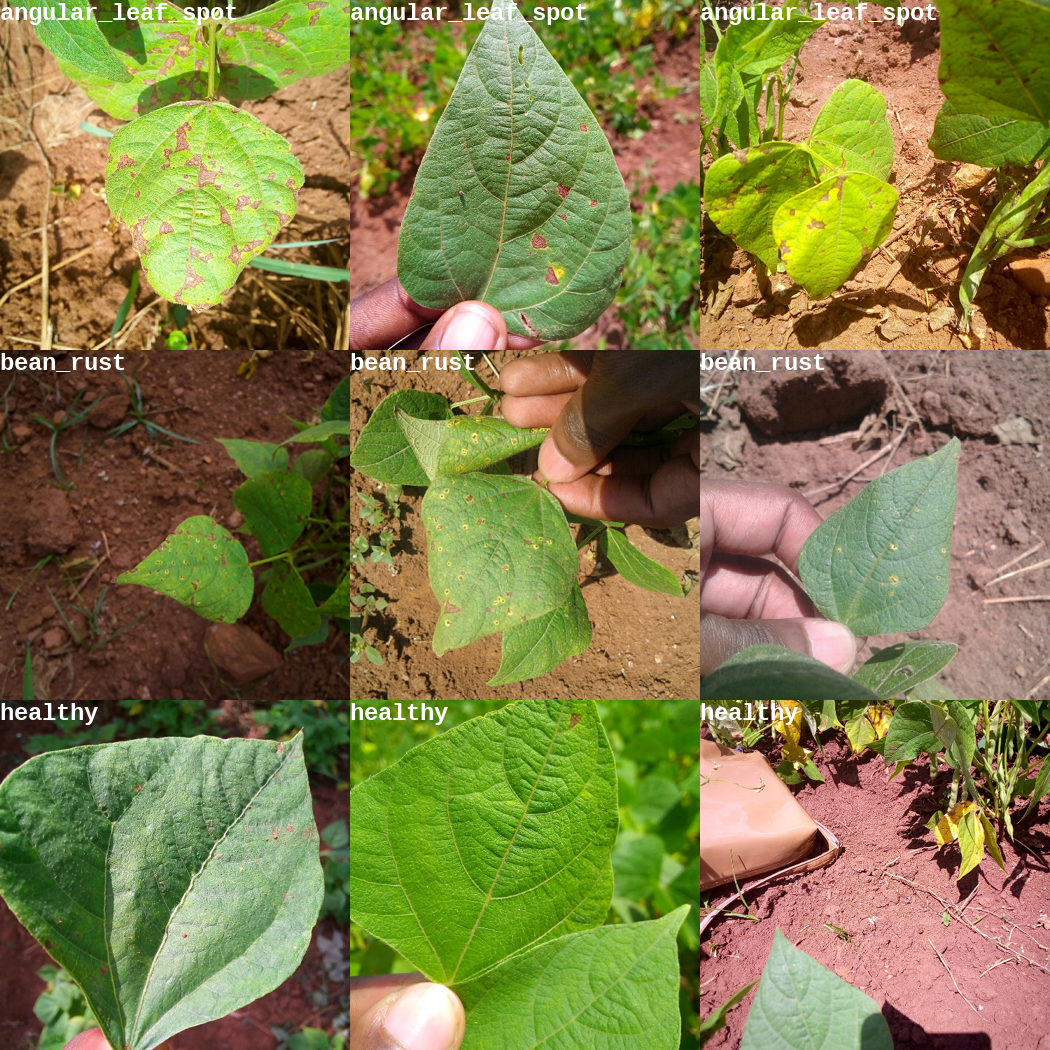

In [8]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

### VIT Feature Extractor

In [9]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [11]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.4588, -0.3961, -0.2706,  ..., -0.0039, -0.0196, -0.1059],
          [-0.4667, -0.4196, -0.2784,  ..., -0.0353, -0.0588, -0.1137],
          [-0.3020, -0.3569, -0.2706,  ..., -0.0275, -0.0431, -0.1059],
          ...,
          [ 0.7569,  0.7804,  0.7333,  ..., -0.3020, -0.2784, -0.2706],
          [ 0.7490,  0.7725,  0.7569,  ..., -0.3176, -0.2784, -0.2549],
          [ 0.7961,  0.8118,  0.7490,  ..., -0.3725, -0.3176, -0.2863]],

         [[-0.1843, -0.0902,  0.0118,  ..., -0.4667, -0.4824, -0.5686],
          [-0.2392, -0.1529, -0.0196,  ..., -0.4745, -0.4980, -0.5686],
          [-0.3412, -0.2941, -0.1216,  ..., -0.3961, -0.3961, -0.4902],
          ...,
          [ 0.2784,  0.2784,  0.2000,  ...,  0.0353,  0.0980,  0.1216],
          [ 0.2314,  0.2471,  0.2235,  ...,  0.0039,  0.0902,  0.1373],
          [ 0.2627,  0.2784,  0.2157,  ..., -0.0667,  0.0353,  0.1059]],

         [[-0.6941, -0.5843, -0.5059,  ..., -0.5922, -0.5922, -0.6706],
          [-0

### Processing the Dataset

In [12]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [13]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.0667, -0.1294, -0.3804,  ..., -0.8745, -0.9059, -0.8824],
          [-0.1216, -0.2078, -0.2314,  ..., -0.8588, -0.8980, -0.8980],
          [-0.2863, -0.3176, -0.3176,  ..., -0.8588, -0.8824, -0.8902],
          ...,
          [-0.2000, -0.3020, -0.3020,  ..., -0.3098, -0.2157, -0.2863],
          [-0.2863, -0.2863, -0.2471,  ..., -0.4275, -0.3725, -0.4196],
          [-0.2941, -0.2706, -0.2078,  ..., -0.3647, -0.3961, -0.4588]],

         [[-0.4667, -0.5216, -0.7490,  ..., -0.8510, -0.8745, -0.8510],
          [-0.5529, -0.6157, -0.6078,  ..., -0.8353, -0.8667, -0.8667],
          [-0.6549, -0.6706, -0.6549,  ..., -0.8353, -0.8588, -0.8588],
          ...,
          [-0.5843, -0.6706, -0.6706,  ..., -0.4431, -0.4431, -0.5529],
          [-0.6784, -0.6941, -0.6784,  ..., -0.3961, -0.4353, -0.5137],
          [-0.6863, -0.6941, -0.6549,  ..., -0.2784, -0.3490, -0.4275]],

         [[-0.5529, -0.5922, -0.7961,  ..., -0.9608, -0.9843, -0.9608],
          [-0

In [14]:
ds = load_dataset('beans')

def transform(example_batch):
    
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    inputs['labels'] = example_batch['labels']
    
    return inputs

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
prepared_ds = ds.with_transform(transform)

In [16]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.0667, -0.1294, -0.3804,  ..., -0.8745, -0.9059, -0.8824],
          [-0.1216, -0.2078, -0.2314,  ..., -0.8588, -0.8980, -0.8980],
          [-0.2863, -0.3176, -0.3176,  ..., -0.8588, -0.8824, -0.8902],
          ...,
          [-0.2000, -0.3020, -0.3020,  ..., -0.3098, -0.2157, -0.2863],
          [-0.2863, -0.2863, -0.2471,  ..., -0.4275, -0.3725, -0.4196],
          [-0.2941, -0.2706, -0.2078,  ..., -0.3647, -0.3961, -0.4588]],

         [[-0.4667, -0.5216, -0.7490,  ..., -0.8510, -0.8745, -0.8510],
          [-0.5529, -0.6157, -0.6078,  ..., -0.8353, -0.8667, -0.8667],
          [-0.6549, -0.6706, -0.6549,  ..., -0.8353, -0.8588, -0.8588],
          ...,
          [-0.5843, -0.6706, -0.6706,  ..., -0.4431, -0.4431, -0.5529],
          [-0.6784, -0.6941, -0.6784,  ..., -0.3961, -0.4353, -0.5137],
          [-0.6863, -0.6941, -0.6549,  ..., -0.2784, -0.3490, -0.4275]],

         [[-0.5529, -0.5922, -0.7961,  ..., -0.9608, -0.9843, -0.9608],
          [-0

In [17]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.0667, -0.1294, -0.3804,  ..., -0.8745, -0.9059, -0.8824],
          [-0.1216, -0.2078, -0.2314,  ..., -0.8588, -0.8980, -0.8980],
          [-0.2863, -0.3176, -0.3176,  ..., -0.8588, -0.8824, -0.8902],
          ...,
          [-0.2000, -0.3020, -0.3020,  ..., -0.3098, -0.2157, -0.2863],
          [-0.2863, -0.2863, -0.2471,  ..., -0.4275, -0.3725, -0.4196],
          [-0.2941, -0.2706, -0.2078,  ..., -0.3647, -0.3961, -0.4588]],

         [[-0.4667, -0.5216, -0.7490,  ..., -0.8510, -0.8745, -0.8510],
          [-0.5529, -0.6157, -0.6078,  ..., -0.8353, -0.8667, -0.8667],
          [-0.6549, -0.6706, -0.6549,  ..., -0.8353, -0.8588, -0.8588],
          ...,
          [-0.5843, -0.6706, -0.6706,  ..., -0.4431, -0.4431, -0.5529],
          [-0.6784, -0.6941, -0.6784,  ..., -0.3961, -0.4353, -0.5137],
          [-0.6863, -0.6941, -0.6549,  ..., -0.2784, -0.3490, -0.4275]],

         [[-0.5529, -0.5922, -0.7961,  ..., -0.9608, -0.9843, -0.9608],
          [-0

### Training and Evaluation

In [18]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


In [19]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


### Loading Pre-Trained Model

In [20]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


### Train 🚀

In [23]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260


Step,Training Loss,Validation Loss,Accuracy
100,0.118800,0.081284,0.977444
200,0.040800,0.047024,0.984962


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-100
Configuration saved in ./vit-base-beans/checkpoint-100/config.json
Model weights saved in ./vit-base-beans/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-200
Configuration saved in ./vit-base-beans/checkpoint-200/config.json
Model weights saved in ./vit-base-beans/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans/checkpoint-200 (score: 0.04702414572238922).
Saving model checkpoint to ./vit-base-beans
Configuration saved in ./vit-base-beans/config.json
Model weights saved in ./vit

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1406
  train_runtime            =  0:02:09.20
  train_samples_per_second =      32.011
  train_steps_per_second   =       2.012


### Evaluate 📊

In [24]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.985
  eval_loss               =      0.047
  eval_runtime            = 0:00:04.18
  eval_samples_per_second =     31.809
  eval_steps_per_second   =      4.066
